In [2]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from scipy import stats

In [3]:
s1 = 'E:/Old Downloads Folder/Research Stuff/Jupyter Notebooks/Coords Folder/Weather Station Coords/'

In [50]:
# This finds the initial step, stopping point, and step size of the files in your directory
def findFiles(code, filepath):

    total_steps = 0
    i = 0
    first_file = False
    final = 0
    
    # Remove parts of the filename that aren't weather station code
    with os.scandir(filepath + code) as entries:
        bad_strings = [code, '_', '.txt']
        
        for entry in entries: 
            file_name = entry.name
            for string in bad_strings: file_name = file_name.replace(string, '')
            if float(file_name) > final: final = float(file_name)
            if first_file == False:
                i = float(file_name)
                first_file = True

            total_steps += 1

    step = round((final - i)/(total_steps - 1), 5)
    print(code)
    return(i, final, step)


# Finding the R^2 value of our curve fitting prediction
# Found here: https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def findR2(fun, x, y, popt):
    residuals = y - fun(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)


# Our function!
def expFunc(x, a, b): return a*x**b


# Find the range at which our distribution has an exponent around -1 with a good R2
def findRange(code, filepath):
    i, final, step = findFiles(code, filepath)
    column_names = ['Ovito Range', 'coeff', 'exp', 'R2']
    final_frame = pd.DataFrame(columns = column_names)
    
    s2 = '/' + code + '_'
    
    best_range = 0
    best_r2 = 0
    best_diff = np.inf
    
    # The loop that does everything yeet
    while i < final:
        
        # I could not figure out how to intelligently round the numbers so make sure to check this before running!!
        i = round(i, 5)
        openpath = filepath + code + s2 + str(i) + '.txt'
        
        with open(openpath) as file:
            data = pd.read_csv(file, sep=',', names=['Size'], skiprows=[0])

        data.index = data.index + 1
        data = data.reset_index()
        xdata = data['index']
        ydata = data['Size']
        
        variables, covariance = curve_fit(expFunc, xdata, ydata)
        R2 = findR2(expFunc, xdata, ydata, variables)
        range_diff = abs(1 - abs(variables[1]))
        
        if range_diff < best_diff:
            best_diff = range_diff
            best_range = i

        i += step
        
    return best_range


# This normalized our distribution so that we can compare it to a Zipfian distribution
def normalizedDistribution(code, filepath):
    file = filepath + code + '/' + code + '_' + str(findRange(code, filepath)) + '.txt'
    data = pd.read_csv(file, sep=',', names=['Size'], skiprows=[0])
    data = data.divide(data['Size'].sum())
    return data['Size'].tolist()


# This finds the max difference between any point in the building rank-size disribution and the expected value
# from a perfect exponential distribution.
def findKs(code, filepath):
    
    # This bit creates the proper Zipfian distribution
    data = normalizedDistribution(code, filepath)
    hi = len(data)
    zipDist = []
    for i in range(1, hi+1):
        zipDist.append(1/i)
    totalVal = sum(zipDist)
    zipDist[:] = [val/totalVal for val in zipDist]
    
    # This block finds the max difference
    maxDist = 0
    for i in range(len(data)):
        diff = abs(data[i] - zipDist[i])
        if diff > maxDist: maxDist = diff
    
    # Plot the specific weather station code you want
    if code == 'USW00023130':
        
        n = 30
        sns.scatterplot(x=np.arange(0, hi)[:n], y=data[:n])
        sns.scatterplot(x=np.arange(0, hi)[:n], y=zipDist[:n])
    
    return maxDist

USW00023130


E:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.14419707969961698

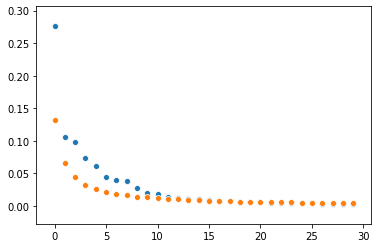

In [51]:
findKs('USW00023130', s1 + 'Los Angeles/')

USC00360022
USC00360861
USC00362574
USC00365573
USC00365918
USW00014762
USW00094823
USW00023130
USW00093134


,Code,Ks
0,USC00360022,0.050472
1,USC00360861,0.085124
2,USC00362574,0.053122
3,USC00365573,0.019655
4,USC00365918,0.024495
5,USW00014762,0.072417
6,USW00094823,0.036797
7,USW00023130,0.144197
8,USW00093134,0.072975


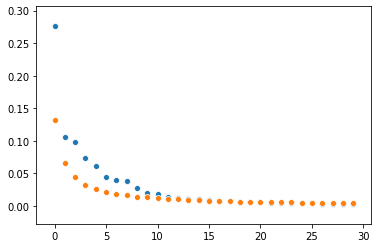

In [43]:
s2 = s1 + 'Los Angeles/'

full_frame = pd.DataFrame(columns=['Code', 'Ks'])

for s in [s1, s2]:
    output = [dI for dI in os.listdir(s) if os.path.isdir(os.path.join(s ,dI))]
    for name in output:
        if name[:2] == 'US':
            temp_df = pd.DataFrame([[name, findKs(name, s)]], columns=['Code', 'Ks'])
            full_frame = full_frame.append(temp_df, ignore_index=True)     
            
full_frame